# Line ratios from saved moment images

In this notebook, I will work with only pre-calculated line maps, which have already been extracted from the cube and have been corrected for the sky problems (at least in theory).  The extraction process is carried out in the 03 series of notebooks.

In [8]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Image
import regions
import sys
import pandas as pd
import pyneb as pn

sns.set_context("talk")
sns.set_color_codes()

## Calculate reddening from Balmer decrement

Load the Hα and Hβ maps

In [2]:
imha = Image("../data/ngc346-hi-6563-bin01-sum.fits")

In [3]:
imhb = Image("../data/ngc346-hi-4861-bin01-sum.fits")

### Look at the raw Hα/Hβ ratio:

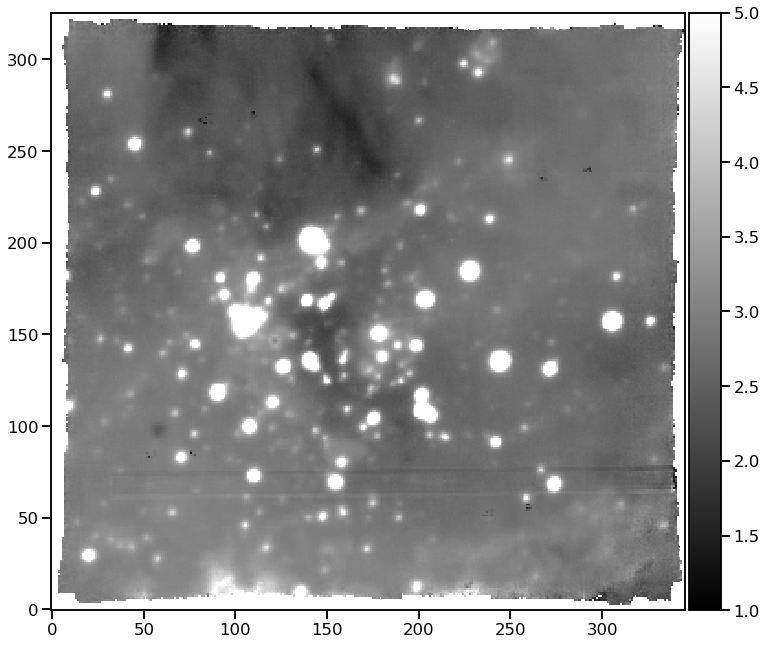

In [7]:
fig, ax = plt.subplots(figsize=(12, 12))
(imha/imhb).plot(vmin=1.0, vmax=5.0, cmap="gray", colorbar="v")

So we see a lot of structure there.  In priniciple, lighter means more extinction.  This seems to be real at the bottom of the image, where we see clear signs of the foreground filament. 

But in other parts, the ratio is suspiciously well correlated with the brightness.  So we need to fix that.

### PyNeb calculation of intrinsic Balmer decrement

In [19]:
hi = pn.RecAtom("H", 1)

Calculate the theoretical Balmer decrement from PyNeb. Density and temperature from Valerdi:2019a

In [27]:
tem, den = 12500, 100
R0 = hi.getEmissivity(tem, den, wave=6563) / hi.getEmissivity(tem, den, wave=4861)
R0

2.8205128205128207

### Look at correlation between Hα and Hβ in the faint limit

To make thinks easier, I multiply the Hb values by R0 so we have a square plot.  I zoom in on the faint parts:

In [32]:
imax = 30000
m = imha.data < imax
m = m & (R0*imhb.data < imax)
m = m & ~imha.mask & ~imhb.mask
df = pd.DataFrame(
    {
        "ha": imha.data[m],
        "hb": R0*imhb.data[m],
    }
)

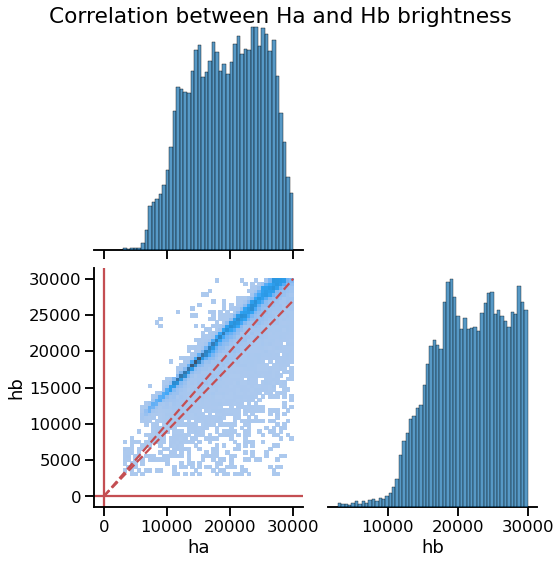

In [36]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, 0.9*imax], "--", color="r")
g.fig.suptitle("Correlation between Ha and Hb brightness");

So, the slope is not unity, meaning the extinction is not zero.  But the intercept is not zero either. Clearly, we must fix that

### Correct zero point of Hβ map

In [41]:
x = imha.data
y = R0*imhb.data - 5500
imax = 30000
m = (x < imax) & (y < imax)
m = m & ~imha.mask & ~imhb.mask
df = pd.DataFrame(
    {
        "ha": x[m],
        "hb": y[m],
    }
)

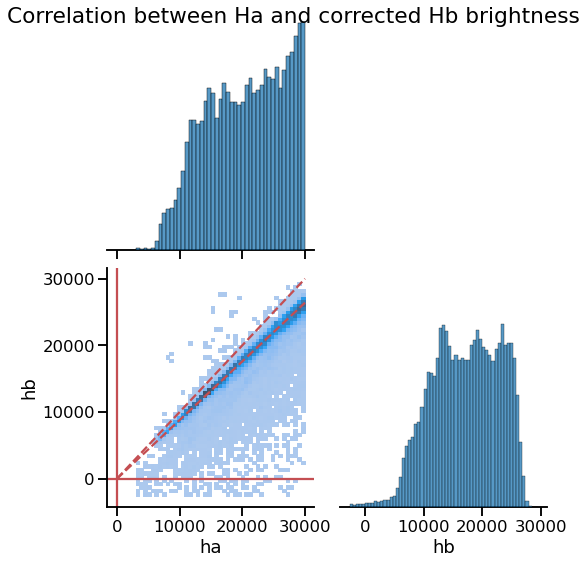

In [43]:
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, 0.88*imax], "--", color="r")
g.fig.suptitle("Correlation between Ha and corrected Hb brightness");

That looks way better.  Expand out to brighter pixels:

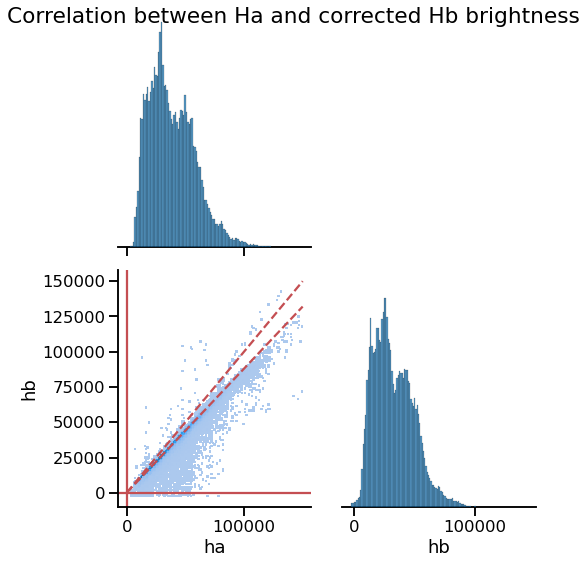

In [45]:
imax = 150000
m = (x < imax) & (y < imax)
m = m & ~imha.mask & ~imhb.mask
df = pd.DataFrame(
    {
        "ha": x[m],
        "hb": y[m],
    }
)
g = sns.pairplot(
    df,
    kind="hist",
    height=4,
    corner=True,
)
g.axes[1, 0].axvline(0.0, color="r")
g.axes[1, 0].axhline(0.0, color="r")
g.axes[1, 0].plot([0, imax], [0, imax], "--", color="r")
g.axes[1, 0].plot([0, imax], [0, 0.88*imax], "--", color="r")
g.fig.suptitle("Correlation between Ha and corrected Hb brightness");

### Final corrected Hα/Hβ ratio image

Now fix the Hb image and try again:

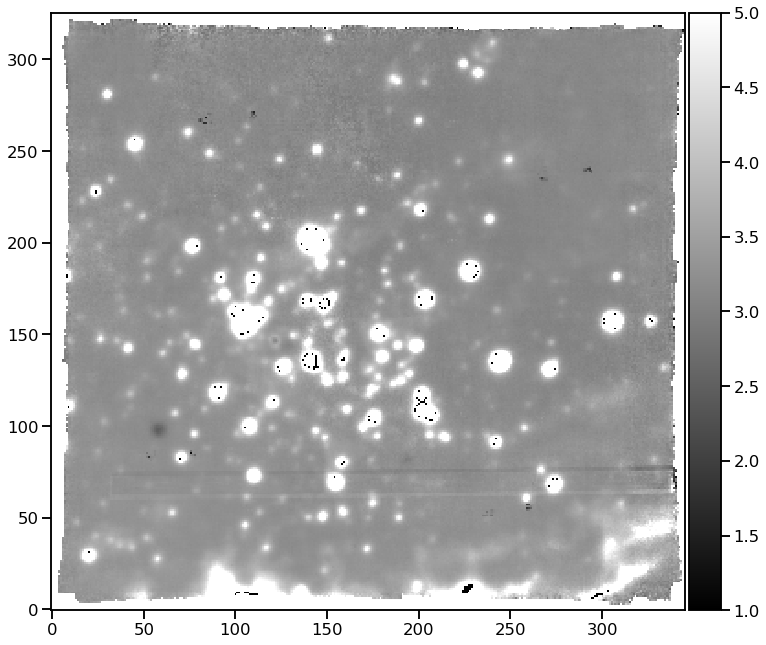

In [46]:
hbfix = 5500 / R0
fig, ax = plt.subplots(figsize=(12, 12))
(imha/(imhb - hbfix)).plot(vmin=1.0, vmax=5.0, cmap="gray", colorbar="v")

That is on the same brightness map as before, and it now completely eliminates the spurious structure associate with surface brightness – hurray!

Now define some regions to take averages

In [59]:
boxes = {
    "sw filament": regions.BoundingBox(
        iymin=30, iymax=50, ixmin=300, ixmax=330,
    ),
    "bow shock": regions.BoundingBox(
        iymin=165, iymax=205, ixmin=240, ixmax=290,
    ),
    "w filament": regions.BoundingBox(
        iymin=100, iymax=130, ixmin=25, ixmax=55,
    ),
    "c filament": regions.BoundingBox(
        iymin=195, iymax=210, ixmin=155, ixmax=195,
    ),
}

Plot on a better scale and show the regions:

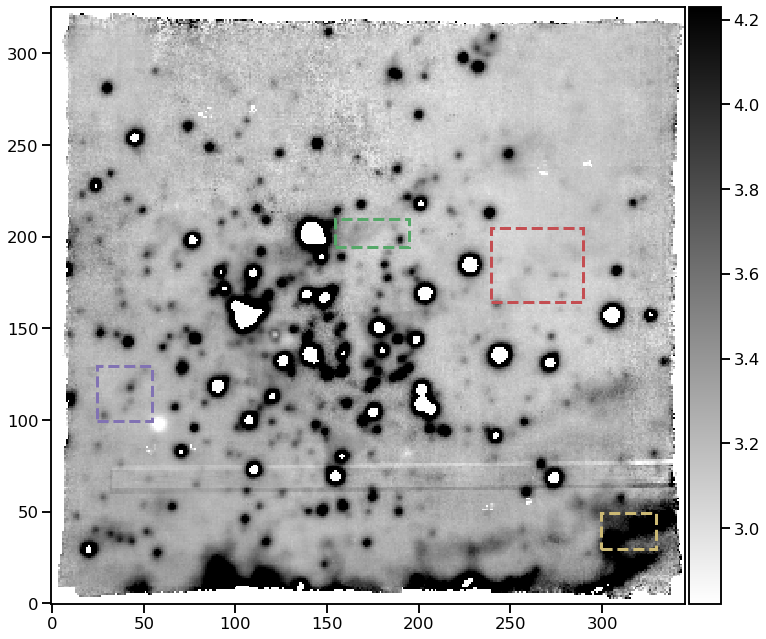

In [63]:
fig, ax = plt.subplots(figsize=(12, 12))
(imha/(imhb - hbfix)).plot(
    vmin=R0, vmax=1.5*R0, 
    scale="linear",
    cmap="gray_r", colorbar="v",
)

for box, c in zip(boxes.values(), "yrmgc"):
    box.plot( 
        ax=ax, 
        lw=3, 
        edgecolor=c, 
        linestyle="dashed",
#        facecolor=(1.0, 1.0, 1.0, 0.4), 
        fill=False,
    );

We can see some very high extinction at in the S filaments.  And some small increase in extinction in the main diagonal filament.  This is probably limited having foreground emission to some extent.

Look at average values in the sample boxes

In [68]:
for label, box in boxes.items():
    yslice, xslice = box.slices
    ha = np.median(imha[yslice, xslice].data.data)
    hb = np.median(imhb[yslice, xslice].data.data - hbfix)
    print(f"{label}: {ha/hb:.3f}")

sw filament: 4.165
bow shock: 3.123
w filament: 3.285
c filament: 3.247


I tried mean and median, and it made very little difference.  Lowest in the bow shock region; slightly higher in the west and central filaments.  Much higher in the southwest filament. 

### The reddening law

In [55]:
pn.RedCorr().getLaws()

dict_keys(['No correction', 'CCM89', 'CCM89 Bal07', 'CCM89 oD94', 'S79 H83 CCM89', 'K76', 'SM79 Gal', 'G03 LMC', 'MCC99 FM90 LMC', 'F99-like', 'F99', 'F88 F99 LMC'])

PyNeb does not seem to have anything specifically tailored to the SMC.  The average SMC extinction law is supposedly simply $1/\lambda$.  

But, it is possible to get a SMC curve by using the "F99-like" option, which uses the curve of Fitzpatrick & Massa 1990, ApJS, 72, 163. This depends on $R_V$ and 6 other parameters (!!!).  Most of the parameters only affect the UV part of the curve, which does not concern us. 

Then, we can use the average values of $R_V$ and the other parameters, which were fit by Gordon:2003l to SMC stars. This is $R_V = 2.74 \pm 0.13$.

So here I compare that SMC curve with $1/\lambda$ and with the Clayton curve for Milky Way (but also adjusted to $R_V = 2.74$):

[(4000.0, 9300.0), (-2.5, 1.0)]

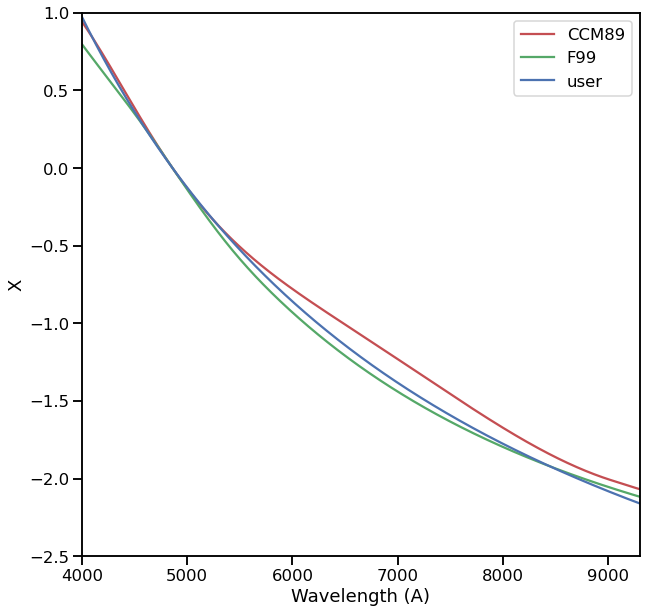

In [157]:
def A_lam(wave):
    return 4861.32/wave

def my_X(wave, params=[]):
    """A_lam / E(B - V) ~ lam^-1"""
    return A_lam(wave) / (A_lam(4400) - A_lam(5500))

rc = pn.RedCorr()
rc.UserFunction = my_X
rc.R_V = 2.74
rc.FitzParams = [-4.96, 2.26, 0.39, 0.6, 4.6, 1.0]
f, ax = plt.subplots(figsize=(10,10))
rc.plot(laws = ["user", "F99", "CCM89"], ax=ax)

ax.set(
    xlim=[4000, 9300],
    ylim=[-2.5, 1.0],
#    xlim=[4000, 7000],
#    ylim=[-1, 1],

)

So the Gordon curve is flatter in the blue, steeper in green, and flatter in red, as compared to $1/\lambda$. 

In [161]:
rc = pn.RedCorr()
rc.R_V = 2.74
rc.FitzParams = [-4.96, 2.26, 0.39, 0.6, 4.6, 1.0]
rc.law = "F99"

Test it out for the bow shock region:

In [166]:
rc.setCorr(obs_over_theo=3.123 / R0, wave1=6563., wave2=4861.)
rc.E_BV, rc.cHbeta

(array(0.08918852), 0.11614443544515392)

And for the highest extinction region

In [165]:
rc.setCorr(obs_over_theo=4.165 / R0, wave1=6563., wave2=4861.)
rc.E_BV, rc.cHbeta

(array(0.3412549), 0.44439418598965574)

So $E(B - V)$ varies from about 0.1 to about 0.35. This is similar to what is found for the stars. 

### The reddening map

We can now make a map of $E(B - V)$

In [175]:
R = imha/(imhb - hbfix)
rc.setCorr(
    obs_over_theo=R.data / R0, 
    wave1=6563., 
    wave2=4861.
)
imEBV = R.copy()
imEBV.data = rc.E_BV
imEBV.mask = imha.mask | imhb.mask

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/pyneb/extinction/red_corr.py:299: RuntimeWarning: invalid value encountered in log10
  self.E_BV = 2.5 * np.log10(obs_over_theo) / (f1 - f2)


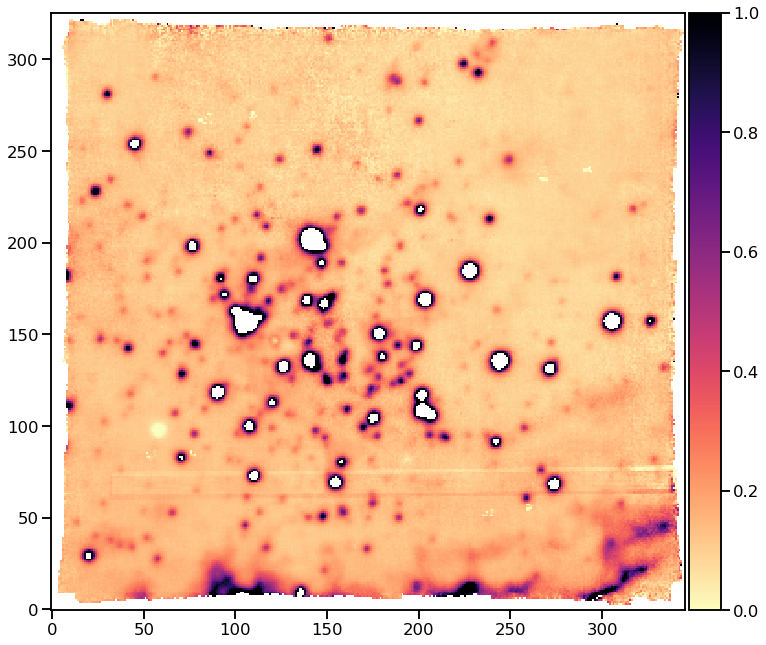

In [181]:
fig, ax = plt.subplots(figsize=(12, 12))
imEBV.plot(
    vmin=0.0, vmax=1.0, 
    scale="linear",
    cmap="magma_r", colorbar="v",
);

Looks like I would expect. Check values in the boxes:

In [182]:
for label, box in boxes.items():
    yslice, xslice = box.slices
    ebv = np.median(imEBV[yslice, xslice].data.data)
    print(f"{label}: {ebv:.3f}")

sw filament: 0.346
bow shock: 0.087
w filament: 0.122
c filament: 0.124


These seem the same as before.  Save it to a file:

In [186]:
imEBV.write("../data/ngc346-reddening-E_BV.fits", savemask="nan")

Lots of regions are affected by the stellar absorption.  There are apparent increases in reddening at the position of each star.  This is not real, but is due to the photospheric absorption having more of an effect on Hb (mainly because the emission line is weaker). 

At some point, I am going to have to deal with that. But it is not an issue for the bow shock emission, since this is in an area free of stars.  We should just use the median bow shock reddening of $E(B-V) = 0.087$ so that we don't introduce any extra noise.

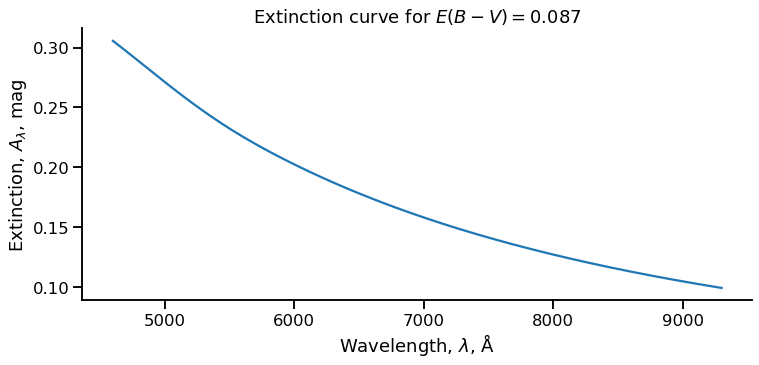

In [198]:
rc.E_BV = 0.087
wavs = np.arange(4600, 9300)
Alam = rc.E_BV*rc.X(wavs)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wavs, Alam)
ax.set(
    xlabel="Wavelength, $\lambda$, Å",
    ylabel="Extinction, $A_\lambda$, mag",
    title=f"Extinction curve for $E(B - V) = {rc.E_BV:.3f}$",
)
sns.despine();